# Getting Started
This notebook shows how to use xrheed to load, inspect, and plot an RHEED example image.

## Load xrheed
First load xrheed and other useful python modules

In [1]:
import xrheed
from xrheed.io import load_data

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

## Load a RHEED image
RHEED images are loaded using the provided plugins.

A plugin should specify the geometry and properties of the particular RHEED setup, including:
- the screen scaling (from pixels to millimeters),
- the screen-to-sample distance,
- the electron beam energy,
- the center of the screen, defined as the midpoint of the line connecting the transmitted beam and the mirror-reflected spot.

The x (horizontal) and y (vertical) coordinates of an image are defined in mm, what means that the plugin needs to transform the px values to real image size using proper scaling.

In [2]:
image_dir = Path("example_data")
image_path = image_dir / "Si_111_7x7_112_phi_00.raw"

rheed_image = load_data(image_path, plugin="dsnp_arpes_raw")

The data are loaded into an xarray object, so the built-in methods of this library are available, as shown below.

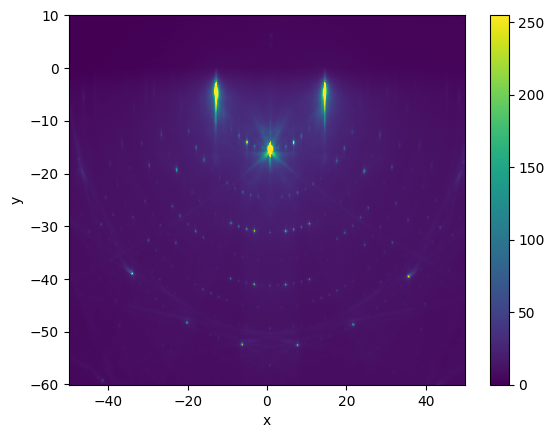

In [3]:
rheed_image.sel(x=slice(-50, 50), y=slice(-60, 10)).plot()
plt.show()

## The .R accessor
Tools dedicated to RHEED analysis are available via the .R accessory. Please revere the API to find all available methods/properties.

For example, you can access basic properties as shown below.

In [4]:
print(rheed_image.R.theta)
print(rheed_image.R.beam_energy)
print(rheed_image.R.screen_scale)

1.0
18600.0
9.6


## RHEED data preparation



### Set the center of an image
Although the plugin used to load the data should provide the information about the screen center, usually we need to know the accurate position of an image centered, that is defined in the following way:
- horizontal center `x=0`, is defined by the line connecting the specular and transited spot,
- vertical center `y=0` is defined at the shadow boundary.

Both values depend on the particular RHEED image setup and usually needs to be fine adjusted for each image or image series.

#### Manual center
The center of an image could be adjusted manually using a method shown bellow.

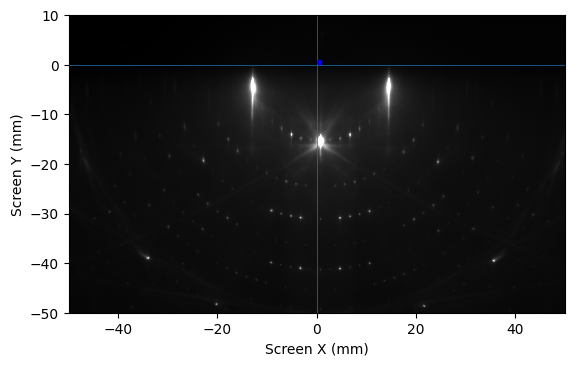

In [5]:
center_x = 0.5  # in mm
center_y = 0.5  # in mm

fig, ax = plt.subplots()
rheed_image.R.plot_image(ax=ax)
ax.plot(center_x, center_y, 'b.')
plt.show()

<Axes: xlabel='Screen X (mm)', ylabel='Screen Y (mm)'>

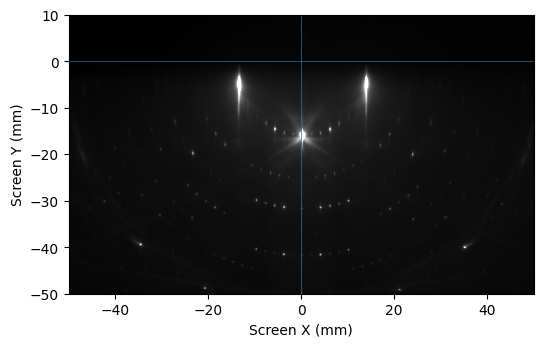

In [6]:
rheed_image.R.apply_image_center(center_x=center_x,
                                  center_y=center_y)

rheed_image.R.plot_image()

### Automated center search
There are two functions in `xrheed.preparation.alignment` that might be used to find vertical and horizontal center.

It is recommended to first find the horizontal center using `find_horizontal_center(image)`, apply the correction and then use `find_vertical_center(image)`. 

Alternatively those functions could be called automatically using, mentioned above accessory `apply_image_center(automatic=True)`.

Please note that automatic center search may not work for asymmetric images.



0.375
-2.0256124726734956


<Axes: xlabel='Screen X (mm)', ylabel='Screen Y (mm)'>

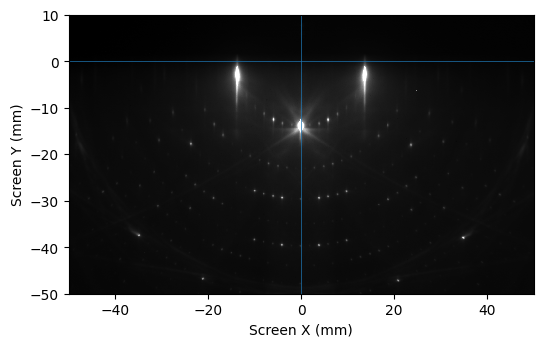

In [7]:
from xrheed.preparation.alignment import find_vertical_center, find_horizontal_center

# try to find center in horizontal
center_x = find_horizontal_center(rheed_image)
center_y = find_vertical_center(rheed_image, shadow_edge_width=5.0)

print(center_x)
print(center_y)

# or use automatic center search
rheed_image.R.apply_image_center(auto_center=True)
rheed_image.R.plot_image()


### Set the incident angle
The plugin adds some default value a theta - incident, grazing angle, but to use Ewald construction this value should be set manually or calculated as shown bellow.

If both: mirror and transition spots are visible on the RHEED image, their position could be used also fur fine adjustment of the shadow edge (`y = 0.0`) position.

Bellow there is an example how to use `find_teheta()` functions provided by the `preparation.alignment` module.

In [8]:
from xrheed.preparation.alignment import find_theta

real_theta = find_theta(rheed_image)

Transmission spot at: 13.92
Mirror spot at: -14.72
Spot distance: 28.65
Shadow edge: -0.40
Theta angle: 2.65


In [9]:
rheed_image.R.theta = real_theta
rheed_image.R

<RHEEDAccessor>
  Image shape: (1038, 1388)
  Screen scale: 9.6
  Screen sample distance: 309.20
  Theta angle: 2.65 deg
  Beam Energy: 18600.0 eV

## Image rotation

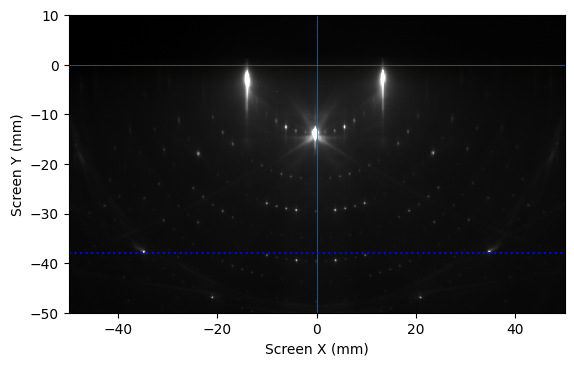

In [10]:
# Create a copy of an image
rotated_image = rheed_image.copy()

# Rotate the image
rotated_image.R.rotate(-0.5)

fig, ax = plt.subplots()
rotated_image.R.plot_image(ax=ax)

# add horizontal line to check the rotation alignment
ax.axhline(-38.0, color='b', linestyle=':')

plt.show()

In [11]:
# Use now the rotated image for further analysis
rheed_image = rotated_image

# Apply automatic center search again after rotation
rheed_image.R.apply_image_center(auto_center=True)

## Screen ROI 
Setup the RHEED image region of interest (ROI) that is used in `plot_image()`

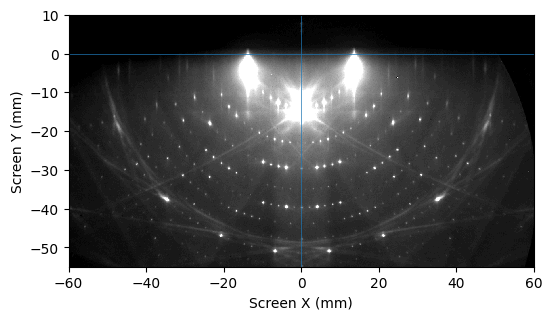

In [16]:
rheed_image.R.screen_roi_width = 60
rheed_image.R.screen_roi_height = 55


# Use automatic levels adjustment
# auto_levels: percentage of pixels to clip at both low and high ends. 
rheed_image.R.plot_image(auto_levels=2.0)
plt.show()

## High pass filter 

Use high pass filter to remove homogenous background signal.

Adjust `sigma` [in mm] and `threshod` values.

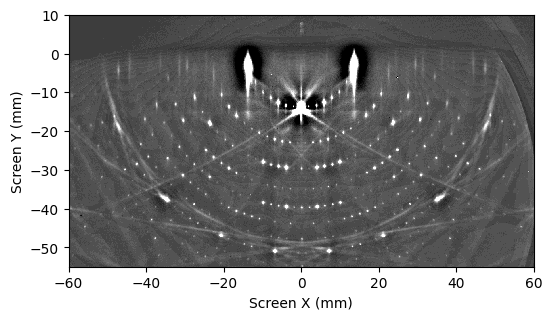

In [22]:
from xrheed.preparation.filters import high_pass_filter

sigma = 1.8 # in mm
sigma_px = sigma * rheed_image.R.screen_scale
threshold = 0.9 

hp_rheed_image = high_pass_filter(rheed_image, sigma=sigma, threshold=threshold)

hp_rheed_image.R.plot_image(auto_levels=1.0,
                            show_center_lines=False)
plt.show()